In [ ]:
# Install libraries for data and indicators
!pip install yfinance pandas numpy joblib ta

# The 'TA-Lib' library (which 'ta' uses) needs a special installation in Colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install TA-Lib

# Install libraries for the dashboard
!pip install streamlit pyngrok

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2de548b277ead396e1ca5972777134bd0152636b828318bb6edc71fa1835319f
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
--2025-10-26 08:18:49--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-10-26 08:18:49--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Let's create a dedicated folder for this project in your Google Drive
import os
PROJECT_PATH = "/content/gdrive/MyDrive/Stock_Prediction_Project/"
if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

print(f"Project folder is ready at: {PROJECT_PATH}")

Mounted at /content/gdrive
Project folder is ready at: /content/gdrive/MyDrive/Stock_Prediction_Project/


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta # Technical Analysis library
from sklearn.preprocessing import MinMaxScaler
import joblib # For saving our scaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Data Fetching ---
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download data
data = yf.download(ticker, start=start_date, end=end_date)

print("--- Original Data (last 5 days) ---")
print(data.tail())

/tmp/ipython-input-355610429.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- Original Data (last 5 days) ---
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-12-23  254.367035  254.745680  252.553466  253.868804  40858800
2024-12-24  257.286682  257.296626  254.386957  254.586262  23234700
2024-12-26  258.103729  259.179926  256.718662  257.276679  27237100
2024-12-27  254.685883  257.784897  252.164833  256.917949  42355300
2024-12-30  251.307861  252.603266  249.862994  251.337754  35557500


In [ ]:
# --- (Previous Step 4 code with fix) ---
import ta # Make sure 'ta' is imported if you're re-running this cell

print(f"Data shape before indicators: {data.shape}")
print(data.head())

# --- FIX ---
# We use .squeeze() to ensure we're passing a 1D Series
# This fixes the "got ndarray of shape (2515, 1)" error
close_prices = data['Close'].squeeze()

# 1. Add 20-day Simple Moving Average (SMA)
data['MA_20'] = ta.trend.sma_indicator(close_prices, window=20)

# 2. Add 14-day Relative Strength Index (RSI)
data['RSI'] = ta.momentum.rsi(close_prices, window=14)
# --- END FIX ---


# --- DEBUGGING LINES ---
print(f"Data length BEFORE dropna: {len(data)}")

# We must drop the first few rows that have 'NaN' (blank) values
data.dropna(inplace=True)

print(f"Data length AFTER dropna: {len(data)}")
# --- END DEBUGGING ---

if len(data) == 0:
    print("\n--- ERROR ---")
    print("Your DataFrame is empty after 'dropna()'.")
    print("This means your date range in Step 3 is too short to calculate the indicators.")
    print("Please go back to Step 3 and use an earlier start_date (e.g., '2015-01-01').")
else:
    print("\n--- Data with Indicators (last 5 days) ---")
    print(data.tail())

# We will train our model on these 3 features
features = ['Close', 'MA_20', 'RSI']

Data shape before indicators: (2515, 5)
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261045  24.729268  23.821670  24.718172  212818400
2015-01-05  23.577579  24.110156  23.391179  24.030269  257142000
2015-01-06  23.579798  23.839428  23.218089  23.641931  263188400
2015-01-07  23.910431  24.010288  23.677428  23.788382  160423600
2015-01-08  24.829126  24.886823  24.121244  24.238856  237458000
Data length BEFORE dropna: 2515
Data length AFTER dropna: 2496

--- Data with Indicators (last 5 days) ---
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2024-12-23  254.367035  254.745680  252.553466  253.868804  40858800   
2024-12-24  257.286682  257.296626  2

In [ ]:
# We will use these 3 features to predict the 'Close' price
feature_data = data[features]

# Create the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# "Fit" the scaler to our data (it learns the min/max values)
# and then "transform" (squish) it.
scaled_data = scaler.fit_transform(feature_data)

# Save the scaler to our Google Drive for later
scaler_filename = os.path.join(PROJECT_PATH, 'stock_scaler.gz')
joblib.dump(scaler, scaler_filename)

print(f"Scaler saved to {scaler_filename}")
print("\n--- Scaled Data (first 5 rows) ---")
print(scaled_data[:5])

Scaler saved to /content/gdrive/MyDrive/Stock_Prediction_Project/stock_scaler.gz

--- Scaled Data (first 5 rows) ---
[[0.02263152 0.01376781 0.60771462]
 [0.02400513 0.01422246 0.64020065]
 [0.0240238  0.01482866 0.64064627]
 [0.02487413 0.01547885 0.66156224]
 [0.02567153 0.01609793 0.68095743]]


In [ ]:
look_back = 60  # We'll use 60 days of history to predict the next day
X = []
y = []

for i in range(look_back, len(scaled_data)):
    # X = The 60 days *before* day 'i', for all 3 features
    X.append(scaled_data[i-look_back:i, :])

    # y = The 'Close' price (column 0) on day 'i'
    y.append(scaled_data[i, 0])

# Convert to NumPy arrays, which Keras needs
X, y = np.array(X), np.array(y)

print(f"\nShape of X (Inputs): {X.shape}")
print(f"Shape of y (Outputs): {y.shape}")
print(f"X shape means: {X.shape[0]} samples, {X.shape[1]} time-steps, {X.shape[2]} features")


Shape of X (Inputs): (2436, 60, 3)
Shape of y (Outputs): (2436,)
X shape means: 2436 samples, 60 time-steps, 3 features


In [ ]:
# We'll use 80% of the data for training, 20% for testing
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")


Training set size: 1948 samples
Test set size: 488 samples


In [ ]:
model = Sequential()

# Layer 1
model.add(LSTM(units=50, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]))) # (60, 3)
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

# Compile the model
# 'adam' is a smart optimizer that adjusts the learning rate automatically
# 'mean_squared_error' is our "grading" function (loss).
# It heavily penalizes big prediction errors.
model.compile(optimizer='adam', loss='mean_squared_error')

# See our model's architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Starting Model Training ---")

history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test)
)

print("--- Model Training Complete ---")

# Save our trained model to Google Drive
model_filename = os.path.join(PROJECT_PATH, 'stock_lstm_model.h5')
model.save(model_filename)
print(f"Model saved to {model_filename}")


--- Starting Model Training ---
Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0176 - val_loss: 0.0040
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0012 - val_loss: 9.3559e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.7026e-04 - val_loss: 6.3983e-04
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 9.3938e-04 - val_loss: 0.0019
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 9.1191e-04 - val_loss: 0.0025
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.9416e-04 - val_loss: 0.0018
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.6974e-04 - val_loss: 0.0020
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 8.2353e-04 - val_loss: 0.002

--- Model Training Complete ---
Model saved to /content/gdrive/MyDrive/Stock_Prediction_Project/stock_lstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

--- Plotting Results ---
Graph saved to /content/gdrive/MyDrive/Stock_Prediction_Project/prediction_graph.png


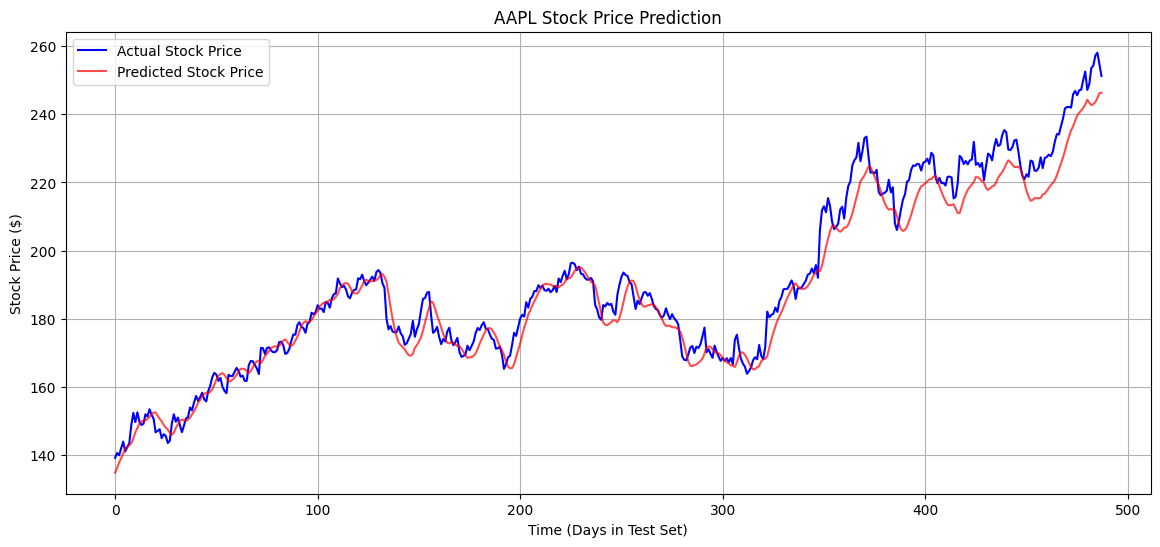

Prediction data saved to /content/gdrive/MyDrive/Stock_Prediction_Project/predictions.csv


In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# --- Inverse Transform (Un-scale) ---
# This is tricky. Our scaler was fit on 3 features ('Close', 'MA_20', 'RSI').
# To "un-squish" our predictions, we need to feed the scaler an array
# with the same 3-column shape.

# 1. Create a dummy array with 3 columns, full of zeros
dummy_array = np.zeros((len(predictions), 3))

# 2. Put our predictions (which are the 'Close' price) into the first column
dummy_array[:, 0] = predictions.flatten()

# 3. Now, inverse transform the whole dummy array
inversed_predictions = scaler.inverse_transform(dummy_array)[:, 0]

# 4. Do the same for the *actual* test answers (y_test)
dummy_y_test = np.zeros((len(y_test), 3))
dummy_y_test[:, 0] = y_test.flatten()
inversed_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]


# --- Plot the results ---
print("\n--- Plotting Results ---")
plt.figure(figsize=(14, 6))
plt.plot(inversed_y_test, color='blue', label='Actual Stock Price')
plt.plot(inversed_predictions, color='red', alpha=0.7, label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time (Days in Test Set)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)

# Save the graph to Google Drive
graph_filename = os.path.join(PROJECT_PATH, 'prediction_graph.png')
plt.savefig(graph_filename)
print(f"Graph saved to {graph_filename}")
plt.show()

# Save the raw prediction data for our dashboard
results_df = pd.DataFrame({
    'Actual': inversed_y_test,
    'Predicted': inversed_predictions
})
results_filename = os.path.join(PROJECT_PATH, 'predictions.csv')
results_df.to_csv(results_filename, index=False)
print(f"Prediction data saved to {results_filename}")

In [ ]:
%%writefile app.py
# This is NOT a notebook cell, it's the contents of a new file 'app.py'

import streamlit as st
import pandas as pd
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
import os

# --- Page Configuration ---
st.set_page_config(
    page_title="Stock Prediction Dashboard",
    page_icon="📈",
    layout="wide"
)

# --- Define the path to our saved files in Google Drive ---
PATH_TO_FILES = "/content/gdrive/MyDrive/Stock_Prediction_Project/"

# --- Caching ---
# We use @st.cache_... so Streamlit doesn't reload the
# (very large) model every time we interact with the app.
@st.cache_data
def load_data(path):
    return pd.read_csv(path)

@st.cache_resource
def load_keras_model(path):
    return load_model(path)

st.title("📈 LSTM Stock Price Prediction Dashboard")
st.write("This dashboard shows the results of our trained LSTM model.")

# --- Load Files ---
try:
    results_df = load_data(os.path.join(PATH_TO_FILES, 'predictions.csv'))
    model = load_keras_model(os.path.join(PATH_TO_FILES, 'stock_lstm_model.h5'))

    st.success("Loaded prediction data and model from Google Drive!")

    # --- Display Interactive Prediction Plot ---
    st.header("Actual vs. Predicted Prices")
    st.write("Use the controls to pan and zoom.")

    # We use Plotly for an interactive web-based chart
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=results_df['Actual'],
        name='Actual Price',
        line=dict(color='blue', width=2)
    ))

    fig.add_trace(go.Scatter(
        y=results_df['Predicted'],
        name='Predicted Price',
        line=dict(color='red', width=2, dash='dot')
    ))

    fig.update_layout(
        xaxis_title="Time (Days in Test Set)",
        yaxis_title="Stock Price ($)",
        hovermode="x unified"
    )

    st.plotly_chart(fig, use_container_width=True)

    # --- Display Model Summary & Data ---
    col1, col2 = st.columns(2)

    with col1:
        st.header("Model Details")
        stringlist = []
        model.summary(print_fn=lambda x: stringlist.append(x))
        model_summary = "\n".join(stringlist)
        st.text(model_summary)

    with col2:
        st.header("Raw Prediction Data")
        st.dataframe(results_df.tail(15))

except FileNotFoundError:
    st.error(f"ERROR: Could not find files at {PATH_TO_FILES}.")
    st.write("Please make sure you have run the notebook and that 'predictions.csv' and 'stock_lstm_model.h5' exist in that Google Drive folder.")
except Exception as e:
    st.error(f"An error occurred: {e}")

Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Terminate any old tunnels
ngrok.kill()

# Start a new tunnel to port 8501 (Streamlit's default port)
public_url = ngrok.connect(8501)
print(f"🚀 Your Streamlit App is live at: {public_url}")

# Run the app!
!streamlit run app.py

ERROR:pyngrok.process.ngrok:t=2025-10-26T08:52:28+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-10-26T08:52:28+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.